# **Homework 2 - Name Entity Recognition (NER) task in zero-shot learning**
**Natural Language Processing** - a.a. 2024/25

**Group:**

- Chemello Francesco - 2121346.
- Volpato Pietro - 2120825.




In [1]:
import os
import sys
from tqdm import tqdm
import numpy as np
import time

# Gemini libraries
from google import genai
from google.genai import types

In [2]:
# To manage environment variables
from google.colab import userdata

## **1 - Dataset**

The dataset choosed is *CONLL-2003*.

[some information about the dataset]

The available NER tags are the following:

- **ORGANIZATION** such as *Georgia-Pacific Corp.*, *WHO
- **PERSON** such as *Eddy Bonte*, *President Obama*.
- **LOCATION** such as *Murray River*, *Mount Everest*.
- **MISCELLANEOUS** - Miscellaneous entities such as *events*, *nationalities*, *products*, or *works of art*.

In [3]:
# To download the dataset
import tensorflow_datasets as tfds

In [4]:
# Download
ds, info = tfds.load("conll2003", split=['train', 'dev', 'test'], with_info=True)
train_ds, val_ds, test_ds = ds
print(info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/conll2003/conll2003/incomplete.6QLYBF_1.0.0/conll2003-train.tfrecord*...: …

Generating dev examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/conll2003/conll2003/incomplete.6QLYBF_1.0.0/conll2003-dev.tfrecord*...:   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/conll2003/conll2003/incomplete.6QLYBF_1.0.0/conll2003-test.tfrecord*...:  …

Dataset conll2003 downloaded and prepared to /root/tensorflow_datasets/conll2003/conll2003/1.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='conll2003',
    full_name='conll2003/conll2003/1.0.0',
    description="""
    The shared task of CoNLL-2003 concerns language-independent named entity
    recognition and concentrates on four types of named entities: persons,
    locations, organizations and names of miscellaneous entities that do not belong
    to the previous three groups.
    """,
    homepage='https://www.aclweb.org/anthology/W03-0419/',
    data_dir='/root/tensorflow_datasets/conll2003/conll2003/1.0.0',
    file_format=tfrecord,
    download_size=959.94 KiB,
    dataset_size=3.87 MiB,
    features=FeaturesDict({
        'chunks': Sequence(ClassLabel(shape=(), dtype=int64, num_classes=23)),
        'ner': Sequence(ClassLabel(shape=(), dtype=int64, num_classes=9)),
        'pos': Sequence(ClassLabel(shape=(), dtype=int64, num_classes=47)),
        

In [5]:
for example in train_ds.take(3):
    print("Tokens: ", example["tokens"].numpy())
    print("NER tags:", example["ner"].numpy())

Tokens:  [b'"' b'If' b'they' b"'re" b'saying' b'at' b'least' b'20' b'percent' b','
 b'then' b'their' b'internal' b'forecasts' b'are' b'probably' b'saying'
 b'25' b'or' b'30' b'percent' b',' b'"' b'said' b'one' b'Sydney' b'media'
 b'analyst' b'who' b'declined' b'to' b'be' b'named' b'.']
NER tags: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0]
Tokens:  [b'Lauck' b"'s" b'lawyer' b'vowed' b'he' b'would' b'appeal' b'against'
 b'the' b'court' b"'s" b'decision' b',' b'arguing' b'that' b'his'
 b'client' b'should' b'have' b'been' b'set' b'free' b'because' b'he'
 b'had' b'not' b'committed' b'any' b'offence' b'under' b'German' b'law'
 b'.']
NER tags: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0]
Tokens:  [b'Thailand' b"'s" b'powerful' b'military' b'thinks' b'the' b'government'
 b'is' b'dishonest' b'and' b'Prime' b'Minister' b'Banharn' b'Silpa-archa'
 b"'s" b'resignation' b'might' b'solve' b'the' b'nation' b"'s"
 b'political' b'and' b'economic' b'woes' 

In [6]:
ner_label_names = info.features["ner"].names
print(ner_label_names)  # ['O', 'B-PER', 'I-PER', 'B-ORG', ...]

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']


In [7]:
sentences = []

# Iterate through the dataset correctly
for example in train_ds.take(3):
    # Access the tokens feature within each example
    tokens = example["tokens"].numpy().astype(str)
    sentence = " ".join(tokens)
    sentences.append(sentence)

In [8]:
for s in sentences:
  print("Example of a phrase: ", s)

Example of a phrase:  " If they 're saying at least 20 percent , then their internal forecasts are probably saying 25 or 30 percent , " said one Sydney media analyst who declined to be named .
Example of a phrase:  Lauck 's lawyer vowed he would appeal against the court 's decision , arguing that his client should have been set free because he had not committed any offence under German law .
Example of a phrase:  Thailand 's powerful military thinks the government is dishonest and Prime Minister Banharn Silpa-archa 's resignation might solve the nation 's political and economic woes , an opinion poll showed on Thursday .


In [9]:
# For "random" shuffle
import random

In [10]:
# Hyperparameter for the minumum number of NER tags that an example should have
# to be taken into consideration.
min_num_tags = 4

In [11]:
# Random shuffle of the examples in the training set
dataset_array = []

for example in train_ds:
  # Count the number of NER tags in the example
  num_tags = 0
  for tag in example["ner"].numpy():
    if tag != 0:
      num_tags += 1
  if num_tags >= min_num_tags:
    # Build the example
    tokens = example["tokens"].numpy().astype(str)
    sentence = " ".join(tokens)
    # Build the NER tag array
    ner_tags = example["ner"].numpy()
    ner_tag_array = []
    for tag in ner_tags:
      ner_tag_array.append(ner_label_names[tag])
    dataset_array.append((sentence, ner_tag_array))

# Print an example
print("Example: ", dataset_array[0])

random.seed(77)

# Shuffle with the random seed
random.shuffle(dataset_array)

# Keep only the first 60 examples
dataset_array = dataset_array[:60]

dataset_sentences_array = []
dataset_labels_array = []

# Create the two arrays for labels and examples
for (x, y) in dataset_array:
  dataset_sentences_array.append(x)
  dataset_labels_array.append(y)

# Print the length
print("Len sentence array: ", len(dataset_sentences_array))
print("Len true label array: ", len(dataset_labels_array))

Example:  ("A forensic scientist who examined the supposed skull of 19th century King Hintsa , a chief of President Nelson Mandela 's Xhosa tribe killed in battle by the British , said it was in fact the cranium of a European woman .", ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'B-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'O'])
Len sentence array:  60
Len true label array:  60


In [12]:
# Keep only the words releated to a NER tag
print("A sentence before the operation: ", dataset_sentences_array[1])
print("A true label before the operation: ", dataset_labels_array[1])

wordpair_sentence_label = []

for i in range(0, len(dataset_labels_array)):
  wordpair_sentence = []
  sentence = dataset_sentences_array[i]
  label = dataset_labels_array[i]
  for i in range (0, len(label)):
    if label[i] != 'O':
      wordpair_sentence.append(((sentence.split(" "))[i], label[i]))
  wordpair_sentence_label.append(wordpair_sentence)

print("A sentence after the operation: ", wordpair_sentence_label[1])

A sentence before the operation:  144 Peter O'Malley ( Australia ) 71 73 , Costantino Rocca ( Italy )
A true label before the operation:  ['O', 'B-PER', 'I-PER', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'B-LOC', 'O']
A sentence after the operation:  [('Peter', 'B-PER'), ("O'Malley", 'I-PER'), ('Australia', 'B-LOC'), ('Costantino', 'B-PER'), ('Rocca', 'I-PER'), ('Italy', 'B-LOC')]


## **2 - NER task with Gemini by Google**

**Gemini** for NER *(Name Entity Recognition)* task

### **Gemini API models and usage**

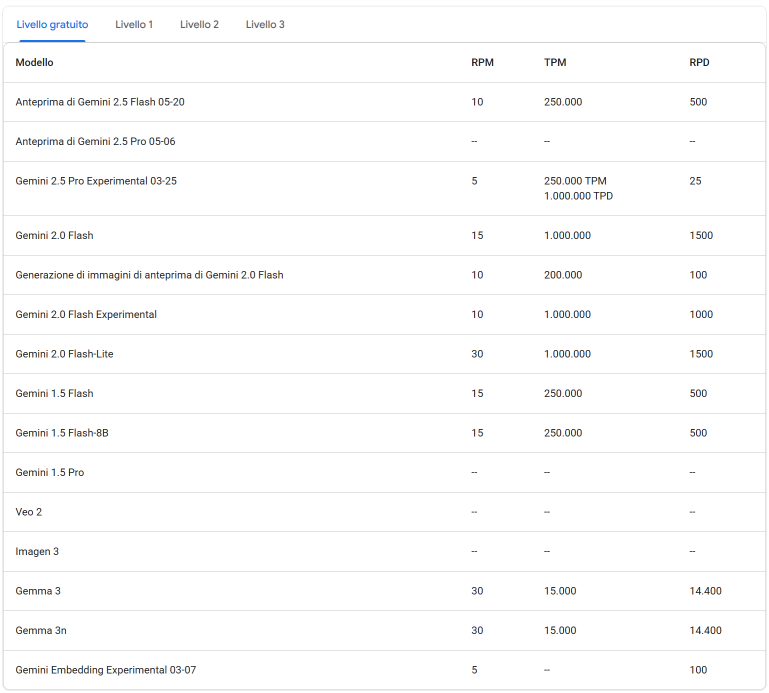

In [13]:
# Available clients
print("Select the model you prefer: ")
print("Model 1: gemini-2.0-flash (default)")
print("Model 2: gemini-2.0-flash-lite")
print("Model 3: gemma-3-14b-it")

# Input user
model_selected = input("\nEnter the number: ")

model_choosed = ""

if model_selected == "1":
  model_choosed = "gemini-2.0-flash"
  print("Model 'gemini-2.0-flash' selected!")
if model_selected == "2":
  model_choosed = "gemini-2.0-flash-lite"
  print("Model 'gemini-2.0-flash-lite' selected!")
elif model_selected == "3":
  model_choosed = "gemma-3-14b-it"
  print("Model 'gemma-3-27b-it' selected!")
else:
  model_choosed = "gemini-2.0-flash"
  print("Unknown model selected!\nDefault model selected!")

Select the model you prefer: 
Model 1: gemini-2.0-flash (default)
Model 2: gemini-2.0-flash-lite
Model 3: gemma-3-14b-it

Enter the number: 2
Model 'gemini-2.0-flash-lite' selected!


In [14]:
# Import for regular expression
import re

# Analysis of the performance
"""
This function calculate the value of:
- true positive (tp).
- false positive (fp).
- false negative (fn).

Returns: tp, fp, fn
"""
def metrics (predicted, true):

  tp = 0
  fp = 0
  fn = 0

  # Pattern that finds all the tuples inside the response
  predicted_tuple = re.findall(r'["\'](.*?)["\']\s*,\s*["\'](.*?)["\']', predicted)

  # Check if there are composed tuples and scompose them if present -> ex. ["New Year", "B-eve"] to ["New", "B-eve"], ["Year", "I-eve"]
  for (x,y) in predicted_tuple:
    if len(x.split(" ")) > 1:
      predicted_tuple.remove((x,y))
      # Get the tag (last part)
      y = y.split("-")[1]
      first_word = True
      for word in x.split(" "):
        # First B-y, other I-y
        if first_word:
          first_word = False
          predicted_tuple.append((word, "B-" + y))
        else:
          predicted_tuple.append((word, "I-" + y))

  # Calculate the true positive (tp) and the false positive (fp)
  temp_true = true.copy()
  for tup in predicted_tuple:
    if tup in temp_true:
      tp += 1
      temp_true.remove(tup)
    else:
      fp += 1

  # Calculate the false negative (fn)
  for tup in true:
    if tup not in predicted_tuple:
      fn += 1

  return tp, fp, fn

In [15]:
# Get the API key from the environment of Google Colab (a.k.a Secrets)
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
client = genai.Client(api_key=GOOGLE_API_KEY)

In [ ]:
# Try a basic prompt with minimal information
tp, fp, fn = 0, 0, 0

# Set up the progress bar
progress_bar = tqdm(total=30)

for i in range(0, 30):
  # Prompt for the task
  prompt = """Given entity label set:
    - Location (LOC).
    - Organization (ORG).
    - Person (PER).
    - Miscellaneos (MISC).
    Based on the given entity label set, please recognize the named entities in the given text.
    You have to use prefixes B (for begin) or I (for inside) together with a tag in the list ahead (for example use "B-PER" and not just "PER").
    You must keep only the words with a relevant tag (the ones I've listed before).
    The result must be in a list of tuples of word-tag like: ("Albert", "B-PER").
    Answer with less words as possible.
    Text: """ + dataset_sentences_array[i] + """
    Result:
    """
  try:
    response = client.models.generate_content(
        model=model_choosed,
        config={
            "temperature": 0.0,  # Set the temperature to 0 for reproducibility
        },
        contents=prompt,
    )

    tem_tp, tem_fp, tem_fn = metrics(response.text, wordpair_sentence_label[i])

    tp += tem_tp
    fp += tem_fp
    fn += tem_fn

    # Sleep to not exeed the API limit
    time.sleep(6)

    progress_bar.update(1)

  # An error occured (probably Gemini is overloaded), so wait 15 seconds
  except Exception as e:
    # Check if the error is releated to the API usage exceeds
    if "429 RESOURCE_EXHAUSTED" in str(e):
      progress_bar.close()
      print(f"API rate limit exceeds at sentence {i}.\nTry with a different model or try again later.")
      sys.exit(1)

    time.sleep(15)

    # Try again
    i = i - 1

progress_bar.close()


100%|██████████| 30/30 [03:21<00:00,  6.72s/it]


In [ ]:
# Analysis of the response using the true label
precision = tp / (tp + fp) if tp + fp > 0 else 0
recall = tp / (tp + fn) if tp + fn > 0 else 0
f1 = (2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0

print("Results: ")
print("Recall: ", recall)
print("Precision: ", precision)
print("F1: ", f1)

Results: 
Recall:  0.7218934911242604
Precision:  0.9172932330827067
F1:  0.8079470198675497


In [ ]:
# Try the promt for the NER task with no extra information
tp, fp, fn = 0, 0, 0

# progress_bar = tqdm(total=len(dataset_sentences_array))
progress_bar = tqdm(total=30)

# for i in range (0, len(dataset_sentences_array)):
for i in range (0, 30):

  # Prompt for the NER task
  prompt = """Do the Name Entity Recognition (also known as NER) task to a following phrase I will give you.
  The only entity labels that could appear in the phrase are:
    - Location (LOC).
    - Organization (ORG).
    - Person (PER).
    - Miscellaneos (MISC).
  You have to use prefixes B (for begin) or I (for inside) together with a tag in the list ahead (for example use "B-PER" and not just "PER").

  You must keep only the words with a relevant tag (the ones I've listed before).

  The result must be in a list of tuples of word-tag like: ("Albert", "B-PER").

  Answer with less words as possible.

  Your phrase is: """ + dataset_sentences_array[i] + """

  Result:
  """

  try:
    response = client.models.generate_content(
        model=model_choosed,
        config={
            "temperature": 0.0,  # Set the temperature to 0 for reproducibility
        },
        contents=prompt,
    )

    tem_tp, tem_fp, tem_fn = metrics(response.text, wordpair_sentence_label[i])

    tp += tem_tp
    fp += tem_fp
    fn += tem_fn

    # Sleep to not exeed the API limit
    time.sleep(6)

    progress_bar.update(1)

  # An error occured (probably Gemini is overloaded), so wait 15 seconds
  except Exception as e:
    # Check if the error is releated to the API usage exceeds
    if "429 RESOURCE_EXHAUSTED" in str(e):
      progress_bar.close()
      print(f"API rate limit exceeds at sentence {i}.\nTry with a different model or try again later.")
      sys.exit(1)

    time.sleep(15)

    # Try again
    i = i - 1

progress_bar.close()

100%|██████████| 30/30 [03:25<00:00,  6.85s/it]


In [ ]:
# Analysis of the response using the true label
precision = tp / (tp + fp) if tp + fp > 0 else 0
recall = tp / (tp + fn) if tp + fn > 0 else 0
f1 = (2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0

print("Results: ")
print("Recall: ", recall)
print("Precision: ", precision)
print("F1: ", f1)

Results: 
Recall:  0.7916666666666666
Precision:  0.9236111111111112
F1:  0.8525641025641026


In [ ]:
# Basic Decomposed QA
tp, fp, fn = 0, 0, 0

progress_bar = tqdm(total=30)

for i in range (0, 30):

  # Prompt for the NER task
  prompt1 = """Do the Name Entity Recognition (also known as NER) task to a following phrase I will give you.
    The only entity labels that could appear in the phrase are:
    - Location (LOC).
    - Organization (ORG).
    - Person (PER).
    - Miscellaneos (MISC).
    You have to use prefixes B (for begin) or I (for inside) together with a tag in the list ahead (for example use "B-LOC" and not just "LOC").
    You must keep only the words with a relevant tag (the ones I've listed before).
    Question: What are the named entities labeled as 'Location'(LOC) in the text?
    The result must be in a list of tuples of word-tag like: ("Thailand", "B-LOC").
    Answer with less words as possible.
    Text: """ + dataset_sentences_array[i] + """
    Result:
    """

  prompt2 = """Do the Name Entity Recognition (also known as NER) task to a following phrase I will give you.
  The only entity labels that could appear in the phrase are:
    - Location (LOC).
    - Organization (ORG).
    - Person (PER).
    - Miscellaneos (MISC).
    You have to use prefixes B (for begin) or I (for inside) together with a tag in the list ahead (for example use "B-ORG" and not just "ORG").
    You must keep only the words with a relevant tag (the ones I've listed before).
    Question: What are the named entities labeled as 'Organization'(ORG) in the text?
    The result must be in a list of tuples of word-tag like: ("Google", "B-ORG").
    Answer with less words as possible.
    Text: """ + dataset_sentences_array[i] + """
    Result:
    """

  prompt3 = """Do the Name Entity Recognition (also known as NER) task to a following phrase I will give you.
  The only entity labels that could appear in the phrase are:
    - Location (LOC).
    - Organization (ORG).
    - Person (PER).
    - Miscellaneos (MISC).
    You have to use prefixes B (for begin) or I (for inside) together with a tag in the list ahead (for example use "B-PER" and not just "PER").
    You must keep only the words with a relevant tag (the ones I've listed before).
    Question: What are the named entities labeled as 'Person'(PER) in the text?
    The result must be in a list of tuples of word-tag like: ("Robert", "B-PER").
    Answer with less words as possible.
    Text: """ + dataset_sentences_array[i] + """
    Result:
    """

  prompt4 = """Do the Name Entity Recognition (also known as NER) task to a following phrase I will give you.
  The only entity labels that could appear in the phrase are:
    - Location (LOC).
    - Organization (ORG).
    - Person (PER).
    - Miscellaneos (MISC).
    You have to use prefixes B (for begin) or I (for inside) together with a tag in the list ahead (for example use "B-MISC" and not just "MISC").
    You must keep only the words with a relevant tag (the ones I've listed before).
    The result must be in a list of tuples of word-tag like: ("Guernica", "B-MISC").
    Answer with less words as possible.
    Text: """ + dataset_sentences_array[i] + """
    Question: What are the named entities labeled as 'Miscellaneos'(MISC) in the text?
    Result:
    """

  prompt = """Do the Name Entity Recognition (also known as NER) task to a following phrase I will give you.
  The only entity labels that could appear in the phrase are:
    - Location (LOC).
    - Organization (ORG).
    - Person (PER).
    - Miscellaneos (MISC).
    You have to use prefixes B (for begin) or I (for inside) together with a tag in the list ahead (for example use "B-MISC" and not just "MISC").
    You must keep only the words with a relevant tag (the ones I've listed before).
    The result must be in a list of tuples of word-tag like: ("Thailand", "B-LOC"), ("Google", "B-ORG"), ("Robert", "B-PER"),("Guernica", "B-MISC").
    Answer each of the following questions one at time:
    - What are the named entities labeled as 'Location'(LOC) in the text?
    - What are the named entities labeled as 'Organization'(ORG) in the text?
    - What are the named entities labeled as 'Person'(PER) in the text?
    - What are the named entities labeled as 'Miscellaneos'(MISC) in the text?
    Answer with less words as possible.
    Text: """ + dataset_sentences_array[i] + """
    Result:
    """

  try:
    # response1 = client.models.generate_content(
    #     model=model_choosed,
    #     config={
    #         "temperature": 0.0,  # Set the temperature to 0 for reproducibility
    #     },
    #     contents=prompt1,
    # )
    # time.sleep(10) # Increased sleep time
    # response2 = client.models.generate_content(
    #     model=model_choosed,
    #     config={
    #         "temperature": 0.0,  # Set the temperature to 0 for reproducibility
    #     },
    #     contents=prompt2,
    # )
    # time.sleep(10) # Increased sleep time
    # response3 = client.models.generate_content(
    #     model=model_choosed,
    #     config={
    #         "temperature": 0.0,  # Set the temperature to 0 for reproducibility
    #     },
    #     contents=prompt3,
    # )
    # time.sleep(10) # Increased sleep time
    # response4 = client.models.generate_content(
    #     model=model_choosed,
    #     config={
    #         "temperature": 0.0,  # Set the temperature to 0 for reproducibility
    #     },
    #     contents=prompt4,
    # )

    # final_response = response1.text + " " +  response2.text + " " +  response3.text + " " +  response4.text

    # tem_tp, tem_fp, tem_fn = metrics(final_response, wordpair_sentence_label[i])

    response = client.models.generate_content(
        model=model_choosed,
        config={
            "temperature": 0.0,  # Set the temperature to 0 for reproducibility
        },
        contents=prompt,
    )

    tem_tp, tem_fp, tem_fn = metrics(response.text, wordpair_sentence_label[i])

    tp += tem_tp
    fp += tem_fp
    fn += tem_fn

    # Sleep to not exeed the API limit
    time.sleep(6)

    progress_bar.update(1)

  # An error occured (probably Gemini is overloaded), so wait 15 seconds
  except Exception as e:
    # Check if the error is releated to the API usage exceeds
    if "429 RESOURCE_EXHAUSTED" in str(e):
      progress_bar.close()
      print(f"API rate limit exceeds at sentence {i}.\nTry with a different model or try again later.")
      sys.exit(1)

    time.sleep(15)

    # Try again
    i = i - 1

progress_bar.close()

100%|██████████| 30/30 [03:43<00:00,  7.43s/it]


In [ ]:
# Analysis of the response using the true label
precision = tp / (tp + fp) if tp + fp > 0 else 0
recall = tp / (tp + fn) if tp + fn > 0 else 0
f1 = (2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0

print("Results: ")
print("Recall: ", recall)
print("Precision: ", precision)
print("F1: ", f1)

Results: 
Recall:  0.7869822485207101
Precision:  0.8866666666666667
F1:  0.8338557993730408


In [ ]:
# Auto write prompt for NER task
tips_autowrite = ""

autowrite = """You must perform a Named Entity Recognition (NER) task on a sentence in a zero-shot setting.
Your goal is to assign a tag to each word, identifying named entities with the highest possible accuracy.

You may consult a short list of classification tips to guide you.

Write this list in the following format:
  - Tip 1: [your tip here].
  - Tip 2: [your tip here].
  - Tip 3: [your tip here].
  ...

Keep each tip short, clear, and specific.

IMPORTANT:
- Only assign entity tags to proper nouns or multi-word expressions that refer to people (PER), locations (LOC), organizations (ORG), or miscellaneous entities (MISC).
- Do **not** assign entity tags to verbs, articles, pronouns, or generic nouns unless they are clearly part of a named entity.
- Prefer precision over recall: if in doubt, tag as "O".

Now write your list of tips:
"""
while(1):
  try:
    autowrite_response = client.models.generate_content(
        model=model_choosed,
        config={
            "temperature": 0.0,  # Set the temperature to 0 for reproducibility
        },
        contents=autowrite,
    )

    tips_autowrite = autowrite_response.text
    print(tips_autowrite)

    break

  # An error occured (probably Gemini is overloaded), so wait 15 seconds
  except Exception as e:
    # Check if the error is releated to the API usage exceeds
    if "429" in str(e):
      progress_bar.close()
      print(f"API rate limit exceeds at sentence {i}.\nTry with a different model or try again later.")
      sys.exit(1)

    time.sleep(15)

- Tip 1: Capitalized words are strong indicators of named entities.
- Tip 2: Look for context clues; is the word referring to a specific place, person, or group?
- Tip 3: Consider common entity patterns (e.g., "Mr. Smith" - PER, "United Nations" - ORG).
- Tip 4: If a word is part of a known entity, tag all consecutive words belonging to that entity.
- Tip 5: If a word is a title (e.g., "President") followed by a name, tag both as PER.



In [ ]:
# Try the auto write prompt for NER task
tp, fp, fn = 0, 0, 0

# progress_bar = tqdm(total=len(dataset_sentences_array))
progress_bar = tqdm(total=30)

# for i in range (0, len(dataset_sentences_array)):
for i in range (0, 30):

  # Prompt for the NER task
  prompt = """
  Do the Name Entity Recognition (also known as NER) task to a following phrase I will give you.
  The only entity labels that could appear in the phrase are:
    - Location (LOC).
    - Organization (ORG).
    - Person (PER).
    - Miscellaneos (MISC).
  You have to use prefixes B (for begin) or I (for inside) together with a tag in the list ahead (for example use "B-PER" and not just "PER").

  You must keep only the words with a relevant tag (the ones I've listed before).

  The result must be in a list of tuples of word-tag like: ("Albert", "B-PER").

  Here some tips that you can find useful:
  """ + tips_autowrite + """

  Answer with less words as possible.

  Your phrase is: """ + dataset_sentences_array[i] + """

  Result:
  """

  try:
    response = client.models.generate_content(
        model=model_choosed,
        config={
            "temperature": 0.0,  # Set the temperature to 0 for reproducibility
        },
        contents=prompt,
    )

    tem_tp, tem_fp, tem_fn = metrics(response.text, wordpair_sentence_label[i])

    tp += tem_tp
    fp += tem_fp
    fn += tem_fn

    # Sleep to not exeed the API limit
    time.sleep(6)

    progress_bar.update(1)

  # An error occured (probably Gemini is overloaded), so wait 15 seconds
  except Exception as e:
    # Check if the error is releated to the API usage exceeds
    if "429" in str(e):
      progress_bar.close()
      print(f"API rate limit exceeds at sentence {i}.\nTry with a different model or try again later.")
      sys.exit(1)

    time.sleep(15)

    # Try again
    i = i - 1

progress_bar.close()

100%|██████████| 30/30 [03:18<00:00,  6.62s/it]


In [ ]:
# Analysis of the response using the true label
precision = tp / (tp + fp) if tp + fp > 0 else 0
recall = tp / (tp + fn) if tp + fn > 0 else 0
f1 = (2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0

print("Results: ")
print("Recall: ", recall)
print("Precision: ", precision)
print("F1: ", f1)

Results: 
Recall:  0.727810650887574
Precision:  0.8482758620689655
F1:  0.7834394904458598


In [ ]:
# Try the prompt for NER task with a step-by-step guide
tp, fp, fn = 0, 0, 0

# progress_bar = tqdm(total=len(dataset_sentences_array))
progress_bar = tqdm(total=30)

# for i in range (0, len(dataset_sentences_array)):
for i in range (0, 30):

  # Prompt for the NER task
  prompt = """
  Do the Name Entity Recognition (also known as NER) task to a following phrase I will give you.
  The only entity labels that could appear in the phrase are:
    - Location (LOC).
    - Organization (ORG).
    - Person (PER).
    - Miscellaneos (MISC).
  You have to use prefixes B (for begin) or I (for inside) together with a tag in the list ahead (for example use "B-PER" and not just "PER").

  Here a step-by-step guide to perform the NER task correctly:
    - Step 1: Read the full sentence and understand its overall meaning. Identify the key subjects, actions, and context.
    - Step 2: Split the sentence into individual words or tokens using whitespace and punctuation as delimiters (e.g., like string.split(" ") in Python).
    - Step 3: For each token, assign one and only one NER tag from the following set:
      - Location (LOC).
      - Organization (ORG).
      - Person (PER).
      - Miscellaneos (MISC).
      - Other, not a named entity (O).
    - Step 4: Use a context window of ±2 tokens to help disambiguate the meaning of each word before assigning a tag. Consider capitalization, surrounding words, and known patterns.
    - Step 5: Repeat step 3 for every token in the sentence, producing a complete list of (token, tag) pairs.
    - Step 6: Reread the sentence together with the assigned tags. Check whether the overall meaning is consistent with what you understood in step 1.
    - Step 7: If the meaning has changed or seems incorrect due to tagging errors, remove all tags and repeat from step 3 using a revised interpretation.
    - Step 8: Once the tagged sentence preserves the original meaning and all entities are accurately labeled, the NER process is complete.

  You must keep only the words with a relevant tag (the ones I've listed before).

  The result must be in a list of tuples of word-tag like: ("Albert", "B-PER").

  Answer with less words as possible.

  Your phrase is: """ + dataset_sentences_array[i] + """

  Result:
  """

  try:
    response = client.models.generate_content(
        model=model_choosed,
        config={
            "temperature": 0.0,  # Set the temperature to 0 for reproducibility
        },
        contents=prompt,
    )

    tem_tp, tem_fp, tem_fn = metrics(response.text, wordpair_sentence_label[i])

    tp += tem_tp
    fp += tem_fp
    fn += tem_fn

    # Sleep to not exeed the API limit
    time.sleep(6)

    progress_bar.update(1)

  # An error occured (probably Gemini is overloaded), so wait 15 seconds
  except Exception as e:
    # Check if the error is releated to the API usage exceeds
    if "429" in str(e):
      progress_bar.close()
      print(f"API rate limit exceeds at sentence {i}.\nTry with a different model or try again later.")
      sys.exit(1)

    time.sleep(15)

    # Try again
    i = i - 1

progress_bar.close()

100%|██████████| 30/30 [03:24<00:00,  6.82s/it]


In [ ]:
# Analysis of the response using the true label
precision = tp / (tp + fp) if tp + fp > 0 else 0
recall = tp / (tp + fn) if tp + fn > 0 else 0
f1 = (2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0

print("Results: ")
print("Recall: ", recall)
print("Precision: ", precision)
print("F1: ", f1)

Results: 
Recall:  0.8383233532934131
Precision:  0.9333333333333333
F1:  0.8832807570977917


In [ ]:
# Syntactic augmentation
tp, fp, fn = 0, 0, 0

progress_bar = tqdm(total=30)

for i in range(0, 30):

  prompt = """Do the Name Entity Recognition (also known as NER) task to a following phrase I will give you.
    The only entity labels that could appear in the phrase are:
      - Location (LOC).
      - Organization (ORG).
      - Person (PER).
      - Miscellaneos (MISC).
      You have to use prefixes B (for begin) or I (for inside) together with a tag in the list ahead (for example use "B-MISC" and not just "MISC").
      You must keep only the words with a relevant tag (the ones I've listed before).
      The result must be in a list of tuples of word-tag like: ("Thailand", "B-LOC"), ("Google", "B-ORG"), ("Robert", "B-PER"),("Guernica", "B-MISC").
      Answer each of the following questions one at time:
      - What are the named entities labeled as 'Location'(LOC) in the text?
      - What are the named entities labeled as 'Organization'(ORG) in the text?
      - What are the named entities labeled as 'Person'(PER) in the text?
      - What are the named entities labeled as 'Miscellaneos'(MISC) in the text?
      Answer following this guideline: First, let's perform Parf-of-Speech tagging. Then, we recognize named entities based on the Part-of-Speech tags.
      Answer with less words as possible.
      Text: """ + dataset_sentences_array[i] + """
      Result:
      """

  try:
    response = client.models.generate_content(
        model=model_choosed,
        config={
            "temperature": 0.0,  # Set the temperature to 0 for reproducibility
        },
        contents=prompt,
    )

    tem_tp, tem_fp, tem_fn = metrics(response.text, wordpair_sentence_label[i])

    tp += tem_tp
    fp += tem_fp
    fn += tem_fn

    time.sleep(6)

    progress_bar.update(1)

  # An error occured (probably Gemini is overloaded), so wait 15 seconds
  except Exception as e:
    # Check if the error is releated to the API usage exceeds
    if "429" in str(e):
      progress_bar.close()
      print(f"API rate limit exceeds at sentence {i}.\nTry with a different model or try again later.")
      sys.exit(1)

    time.sleep(15)

    i = i - 1

progress_bar.close()


  0%|          | 0/30 [01:55<?, ?it/s]

 93%|█████████▎| 28/30 [04:09<00:17,  8.93s/it]


In [ ]:
# Analysis of the response using the true label
precision = tp / (tp + fp) if tp + fp > 0 else 0
recall = tp / (tp + fn) if tp + fn > 0 else 0
f1 = (2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0

print("Results: ")
print("Recall: ", recall)
print("Precision: ", precision)
print("F1: ", f1)

Results: 
Recall:  0.7515923566878981
Precision:  0.8428571428571429
F1:  0.7946127946127947


In [16]:
# Tool augmentation
import spacy

# Extract the PoS tags
pos = spacy.load("en_core_web_sm")

tp, fp, fn = 0, 0, 0

progress_bar = tqdm(total=30)

for i in range(0, 30):
  doc = pos(dataset_sentences_array[i])
  pos_tags = " ".join(f"{token.text}/{token.tag_}" for token in doc)

  prompt = """Do the Name Entity Recognition (also known as NER) task to a following phrase I will give you.
    The only entity labels that could appear in the phrase are:
      - Location (LOC).
      - Organization (ORG).
      - Person (PER).
      - Miscellaneos (MISC).
      You have to use prefixes B (for begin) or I (for inside) together with a tag in the list ahead (for example use "B-MISC" and not just "MISC").
      You must keep only the words with a relevant tag (the ones I've listed before).
      The result must be in a list of tuples of word-tag like: ("Thailand", "B-LOC"), ("Google", "B-ORG"), ("Robert", "B-PER"),("Guernica", "B-MISC").
      You are given also the Part-of-Speech tags of the sentence.
      Answer each of the following questions one at time:
      - What are the named entities labeled as 'Location'(LOC) in the text?
      - What are the named entities labeled as 'Organization'(ORG) in the text?
      - What are the named entities labeled as 'Person'(PER) in the text?
      - What are the named entities labeled as 'Miscellaneos'(MISC) in the text?
      Answer following this guideline: Let's infer named entities step by step from the text based on the given Part-of-Speech tags.
      Answer with less words as possible.
      Part-of-Speech tags: """ + pos_tags + """
      Text: """ + dataset_sentences_array[i] + """
      Result:
      """

  try:
    response = client.models.generate_content(
        model=model_choosed,
        config={
            "temperature": 0.0,  # Set the temperature to 0 for reproducibility
        },
        contents=prompt,
    )

    tem_tp, tem_fp, tem_fn = metrics(response.text, wordpair_sentence_label[i])

    tp += tem_tp
    fp += tem_fp
    fn += tem_fn

    time.sleep(6)

    progress_bar.update(1)

  # An error occured (probably Gemini is overloaded), so wait 15 seconds
  except Exception as e:
    # Check if the error is releated to the API usage exceeds
    if "429" in str(e):
      progress_bar.close()
      print(f"API rate limit exceeds at sentence {i}.\nTry with a different model or try again later.")
      sys.exit(1)

    time.sleep(15)

    i = i - 1

progress_bar.close()




100%|██████████| 30/30 [05:26<00:00, 10.89s/it]


In [17]:
# Analysis of the response using the true label
precision = tp / (tp + fp) if tp + fp > 0 else 0
recall = tp / (tp + fn) if tp + fn > 0 else 0
f1 = (2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0

print("Results: ")
print("Recall: ", recall)
print("Precision: ", precision)
print("F1: ", f1)

Results: 
Recall:  0.33136094674556216
Precision:  0.717948717948718
F1:  0.4534412955465587


In [18]:
tips_autowrite = ""

autowrite = """You must perform a Named Entity Recognition (NER) task on a sentence in a zero-shot setting.
Your goal is to assign a tag to each word, identifying named entities with the highest possible accuracy.
For improving the performanca I give you also the part-of_speech tags of the sentence, so consider also this detail on your decision.

You may consult a short list of classification tips to guide you.

Write this list in the following format:
  - Tip 1: [your tip here].
  - Tip 2: [your tip here].
  - Tip 3: [your tip here].
  ...

Keep each tip short, clear, and specific.

IMPORTANT:
- Only assign entity tags to proper nouns or multi-word expressions that refer to people (PER), locations (LOC), organizations (ORG), or miscellaneous entities (MISC).
- Do **not** assign entity tags to verbs, articles, pronouns, or generic nouns unless they are clearly part of a named entity.
- Prefer precision over recall: if in doubt, tag as "O".

Now write your list of tips:
"""
while(1):
  try:
    autowrite_response = client.models.generate_content(
        model=model_choosed,
        config={
            "temperature": 0.0,  # Set the temperature to 0 for reproducibility
        },
        contents=autowrite,
    )

    tips_autowrite = autowrite_response.text
    print(tips_autowrite)

    break

  # An error occured (probably Gemini is overloaded), so wait 15 seconds
  except Exception as e:
    # Check if the error is releated to the API usage exceeds
    if "429" in str(e):
      progress_bar.close()
      print(f"API rate limit exceeds at sentence {i}.\nTry with a different model or try again later.")
      sys.exit(1)

    time.sleep(15)

- Tip 1: Tag capitalized words as potential entities, especially if they are nouns.
- Tip 2: Consider the context and surrounding words when identifying entities.
- Tip 3: Use part-of-speech tags to help identify nouns and proper nouns.
- Tip 4: Multi-word expressions should be tagged as a single entity if they function as a unit (e.g., "United States" as LOC).
- Tip 5: If a word is followed by a comma and then another capitalized word, it's likely part of a named entity.



In [19]:
# Tool augmentation
import spacy

# Extract the PoS tags
pos = spacy.load("en_core_web_sm")

# Try the auto write prompt for NER task
tp, fp, fn = 0, 0, 0

# progress_bar = tqdm(total=len(dataset_sentences_array))
progress_bar = tqdm(total=30)

# for i in range (0, len(dataset_sentences_array)):
for i in range (0, 30):
  doc = pos(dataset_sentences_array[i])
  pos_tags = " ".join(f"{token.text}/{token.tag_}" for token in doc)

  # Prompt for the NER task
  prompt = """
  Do the Name Entity Recognition (also known as NER) task to a following phrase I will give you.
  The only entity labels that could appear in the phrase are:
    - Location (LOC).
    - Organization (ORG).
    - Person (PER).
    - Miscellaneos (MISC).
  You have to use prefixes B (for begin) or I (for inside) together with a tag in the list ahead (for example use "B-PER" and not just "PER").

  You must keep only the words with a relevant tag (the ones I've listed before).

  The result must be in a list of tuples of word-tag like: ("Albert", "B-PER").

  Here some tips that you can find useful:
  """ + tips_autowrite + """
  Here are the Part-of-Speech tags: """ + pos_tags + """

  Answer with less words as possible.

  Your phrase is: """ + dataset_sentences_array[i] + """

  Result:
  """

  try:
    response = client.models.generate_content(
        model=model_choosed,
        config={
            "temperature": 0.0,  # Set the temperature to 0 for reproducibility
        },
        contents=prompt,
    )

    tem_tp, tem_fp, tem_fn = metrics(response.text, wordpair_sentence_label[i])

    tp += tem_tp
    fp += tem_fp
    fn += tem_fn

    # Sleep to not exeed the API limit
    time.sleep(6)

    progress_bar.update(1)

  # An error occured (probably Gemini is overloaded), so wait 15 seconds
  except Exception as e:
    # Check if the error is releated to the API usage exceeds
    if "429" in str(e):
      progress_bar.close()
      print(f"API rate limit exceeds at sentence {i}.\nTry with a different model or try again later.")
      sys.exit(1)

    time.sleep(15)

    # Try again
    i = i - 1

progress_bar.close()

100%|██████████| 30/30 [04:09<00:00,  8.30s/it]


In [20]:
# Analysis of the response using the true label
precision = tp / (tp + fp) if tp + fp > 0 else 0
recall = tp / (tp + fn) if tp + fn > 0 else 0
f1 = (2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0

print("Results: ")
print("Recall: ", recall)
print("Precision: ", precision)
print("F1: ", f1)

Results: 
Recall:  0.8095238095238095
Precision:  0.8292682926829268
F1:  0.8192771084337348


In [21]:
tips_autowrite = ""

autowrite = """You must perform a Named Entity Recognition (NER) task on a sentence in a zero-shot setting.
Your goal is to assign a tag to each word, identifying named entities with the highest possible accuracy.
For improving the performanca I give you also the part-of-speech tags of the sentence and the dependency tree, so consider also these details on your decision.

You may consult a short list of classification tips to guide you.

Write this list in the following format:
  - Tip 1: [your tip here].
  - Tip 2: [your tip here].
  - Tip 3: [your tip here].
  ...

Keep each tip short, clear, and specific.

IMPORTANT:
- Only assign entity tags to proper nouns or multi-word expressions that refer to people (PER), locations (LOC), organizations (ORG), or miscellaneous entities (MISC).
- Do **not** assign entity tags to verbs, articles, pronouns, or generic nouns unless they are clearly part of a named entity.
- Prefer precision over recall: if in doubt, tag as "O".

Now write your list of tips:
"""
while(1):
  try:
    autowrite_response = client.models.generate_content(
        model=model_choosed,
        config={
            "temperature": 0.0,  # Set the temperature to 0 for reproducibility
        },
        contents=autowrite,
    )

    tips_autowrite = autowrite_response.text
    print(tips_autowrite)

    break

  # An error occured (probably Gemini is overloaded), so wait 15 seconds
  except Exception as e:
    # Check if the error is releated to the API usage exceeds
    if "429" in str(e):
      progress_bar.close()
      print(f"API rate limit exceeds at sentence {i}.\nTry with a different model or try again later.")
      sys.exit(1)

    time.sleep(15)

- Tip 1: Look for capitalized words, especially at the beginning of the sentence or after punctuation, as potential named entities.
- Tip 2: Consider words that are part of a multi-word expression, such as "United States" (LOC) or "World Health Organization" (ORG).
- Tip 3: Use the part-of-speech tags to identify proper nouns (NNP, NNPS) as strong candidates for named entities.
- Tip 4: Use the dependency tree to identify words that modify or are modified by a proper noun, as they might be part of the same named entity.
- Tip 5: If a word is a known abbreviation for an organization, tag it as ORG.
- Tip 6: If a word is a title (Mr., Dr., etc.) followed by a name, tag the name as PER.



In [22]:
# Tool augmentation
import spacy

# Extract the PoS tags
pos = spacy.load("en_core_web_sm")

# Try the auto write prompt for NER task
tp, fp, fn = 0, 0, 0

# progress_bar = tqdm(total=len(dataset_sentences_array))
progress_bar = tqdm(total=30)

# for i in range (0, len(dataset_sentences_array)):
for i in range (0, 30):
  doc = pos(dataset_sentences_array[i])
  pos_tags = " ".join(f"{token.text}/{token.tag_}" for token in doc)

  dependency_tree = "\n".join(f"{token.text} ({token.dep_}) --> {token.head.text}" for token in doc)

  # Prompt for the NER task
  prompt = """
  Do the Name Entity Recognition (also known as NER) task to a following phrase I will give you.
  The only entity labels that could appear in the phrase are:
    - Location (LOC).
    - Organization (ORG).
    - Person (PER).
    - Miscellaneos (MISC).
  You have to use prefixes B (for begin) or I (for inside) together with a tag in the list ahead (for example use "B-PER" and not just "PER").

  You must keep only the words with a relevant tag (the ones I've listed before).

  The result must be in a list of tuples of word-tag like: ("Albert", "B-PER").

  Here some tips that you can find useful:
  """ + tips_autowrite + """
  Here are the Part-of-Speech tags: """ + pos_tags + """
  Here are the dependency tree: """ + dependency_tree + """

  Answer with less words as possible.

  Your phrase is: """ + dataset_sentences_array[i] + """

  Result:
  """

  try:
    response = client.models.generate_content(
        model=model_choosed,
        config={
            "temperature": 0.0,  # Set the temperature to 0 for reproducibility
        },
        contents=prompt,
    )

    tem_tp, tem_fp, tem_fn = metrics(response.text, wordpair_sentence_label[i])

    tp += tem_tp
    fp += tem_fp
    fn += tem_fn

    # Sleep to not exeed the API limit
    time.sleep(6)

    progress_bar.update(1)

  # An error occured (probably Gemini is overloaded), so wait 15 seconds
  except Exception as e:
    # Check if the error is releated to the API usage exceeds
    if "429" in str(e):
      progress_bar.close()
      print(f"API rate limit exceeds at sentence {i}.\nTry with a different model or try again later.")
      sys.exit(1)

    time.sleep(15)

    # Try again
    i = i - 1

progress_bar.close()

100%|██████████| 30/30 [03:36<00:00,  7.21s/it]


In [23]:
# Analysis of the response using the true label
precision = tp / (tp + fp) if tp + fp > 0 else 0
recall = tp / (tp + fn) if tp + fn > 0 else 0
f1 = (2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0

print("Results: ")
print("Recall: ", recall)
print("Precision: ", precision)
print("F1: ", f1)

Results: 
Recall:  0.8520710059171598
Precision:  0.8470588235294118
F1:  0.8495575221238938


## **3 - Conclusion**
[conclusion here]